In [18]:
from ase.io import read
import numpy as np
import os
from tqdm.auto import tqdm

from skcosmo.preprocessing import StandardFlexibleScaler
from skcosmo.feature_selection import PCovCUR, PCovFPS, CUR, FPS
from rascal.representations import SphericalInvariants as SOAP
from rascal.utils import radial_basis_functions_gto
from sklearn.linear_model import Ridge, RidgeCV
import matplotlib as mpl
from matplotlib import pyplot as plt
from ase import Atoms
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

plt.rcParams['pdf.fonttype']=42

In [2]:
frames = np.asarray(read('ice_w_props.xyz', ':'), dtype=object)
for frame in frames:
    frame.wrap(eps=1E-10)

energies = np.array([frame.info['energy [eV/H2O]'] for frame in frames])

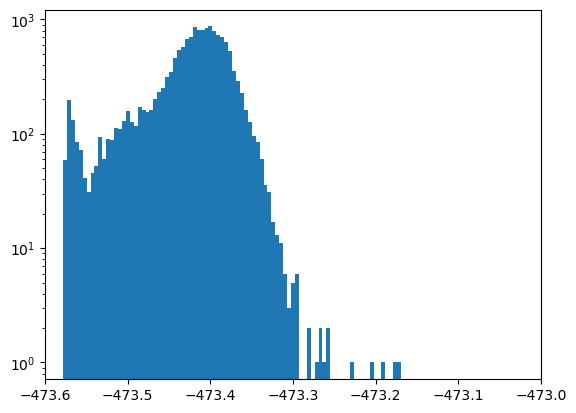

In [3]:
plt.hist(energies, bins=200)
plt.gca().set_yscale('log')
plt.gca().set_xlim([-473.6, -473.0])

frames = frames[np.where(energies<=-473.25)[0]]
energies = energies[np.where(energies<=-473.25)[0]]

In [4]:
y_scaler = StandardFlexibleScaler(column_wise=True)
y = y_scaler.fit_transform(np.vstack(energies))

In [5]:
for frame in frames:
    mask = np.zeros(len(frame), dtype=bool)
    mask[np.where(frame.numbers==8)] = 1
    frame.arrays['center_atoms_mask'] = mask

In [22]:
cutoff=6
radial_hypers = {
    'interaction_cutoff': 5,
    'max_radial': 20,
    'max_angular': 0,
    'gaussian_sigma_constant': 0.2,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.5,
    'radial_basis': 'GTO',
    'expansion_by_species_method': 'user defined',
    'global_species': [1, 8],
    'normalize': False,
    "soap_type": "RadialSpectrum",
}
radial_soap = SOAP(**radial_hypers)

# grid of distances r to compute the g(r) over
rgrid = np.linspace(0, radial_hypers["interaction_cutoff"], 501)
h_min = 0.5
o_min = 2

# GTO orbitals
gto = radial_basis_functions_gto(
        rgrid, 
        radial_hypers["max_radial"], 
        radial_hypers["interaction_cutoff"]
    )

h_igrid = np.where(rgrid>=h_min)[0]
h_rgrid = rgrid[h_igrid]
o_igrid = np.where(rgrid>=o_min)[0]
o_rgrid = rgrid[o_igrid]
GR = np.zeros((len(frames), len(h_rgrid)+len(o_rgrid)))

for fi, frame in enumerate(tqdm(frames)):
    gr = np.zeros((len(h_rgrid)+len(o_rgrid)))
    radial_feat = radial_soap.transform([frame]).get_features(radial_soap)
    
    # O --> H g(r)
    gr[:len(h_igrid)] = np.mean(radial_feat[:, :gto.shape[0]] @ gto, axis=0)[h_igrid]

    # O --> O g(r)
    gr[len(h_igrid):] = np.mean(radial_feat[:, gto.shape[0]:] @ gto, axis=0)[o_igrid]
    
    GR[fi] = gr

  0%|          | 0/15860 [00:00<?, ?it/s]

In [23]:
X2 = StandardFlexibleScaler(column_wise=False).fit_transform(GR)
X2.shape

(15860, 752)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X2,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1,
                                                    shuffle=True)
X_train.shape, X_test.shape

((14274, 752), (1586, 752))

In [25]:
ridge2 = RidgeCV(cv=2, fit_intercept=False, alphas=np.logspace(-8,2,20)).fit(X_train, y_train)
yp2 = ridge2.predict(X_train)

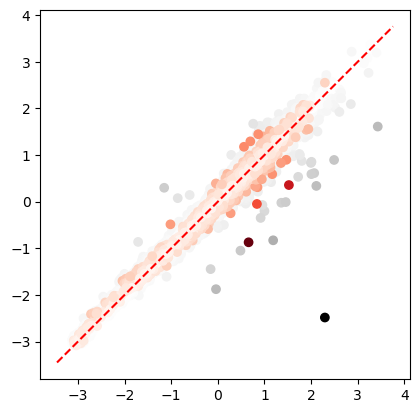

In [26]:
plt.scatter(y_train, yp2, c=np.abs(y_train-yp2), cmap='Greys')
plt.scatter(y_test, ridge2.predict(X_test), c=np.abs(y_test-ridge2.predict(X_test)), cmap='Reds')
plt.plot(plt.gca().get_xlim(), plt.gca().get_xlim(), 'r--')
plt.gca().set_aspect('equal')
plt.show()

In [27]:
ridge2.score(X_test, y_test)

0.9802498274155496

In [28]:
n_select = min(X2.shape[1]-1, 10)
pcovcur2 = PCovCUR(mixing=0., n_to_select=n_select, progress_bar=True).fit(X_train, yp2)
cur2 = CUR(n_to_select=n_select, progress_bar=True).fit(X_train, yp2)
pcovfps2 = PCovFPS(mixing=0., n_to_select=n_select, progress_bar=True, initialize=pcovcur2.selected_idx_[0]).fit(X_train, yp2)
fps2 = FPS(n_to_select=n_select, progress_bar=True, initialize=cur2.selected_idx_[0]).fit(X_train, yp2)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [29]:
def quick_test(idx):
    scoring = lambda yp, y_test: r2_score(y_test, yp)
    return scoring(RidgeCV(cv=5,
                   fit_intercept=False, alphas=np.logspace(-8, 2, 100), scoring='neg_mean_squared_error').fit(
                       X_train[:, idx], y_train).predict(X_test[:, idx]), y_test)

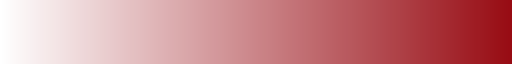

In [30]:
# if you use Reds default cmap then 0 values are still painted slightly red
# that is why we create our own color map which maps the 0 values to white
norm = mpl.colors.Normalize(vmin=0, vmax=1)
custom_Red = mpl.colors.LinearSegmentedColormap.from_list('custom_Red', [(1.0, 1.0, 1.0, 1.0), mpl.cm.Reds(norm(0.9))], N=256)
custom_Red

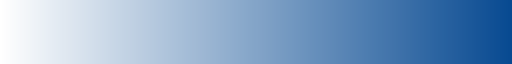

In [31]:
norm = mpl.colors.Normalize(vmin=0, vmax=1)
custom_Blue = mpl.colors.LinearSegmentedColormap.from_list('custom_Blue', [(1.0, 1.0, 1.0, 1.0), mpl.cm.Blues(norm(0.9))], N=256)
custom_Blue

In [53]:
3.75*10/6

6.25

In [94]:
position_xalterations.get((3, 'D'), 0)

0.05

/tmp/ipykernel_2542292/496626498.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


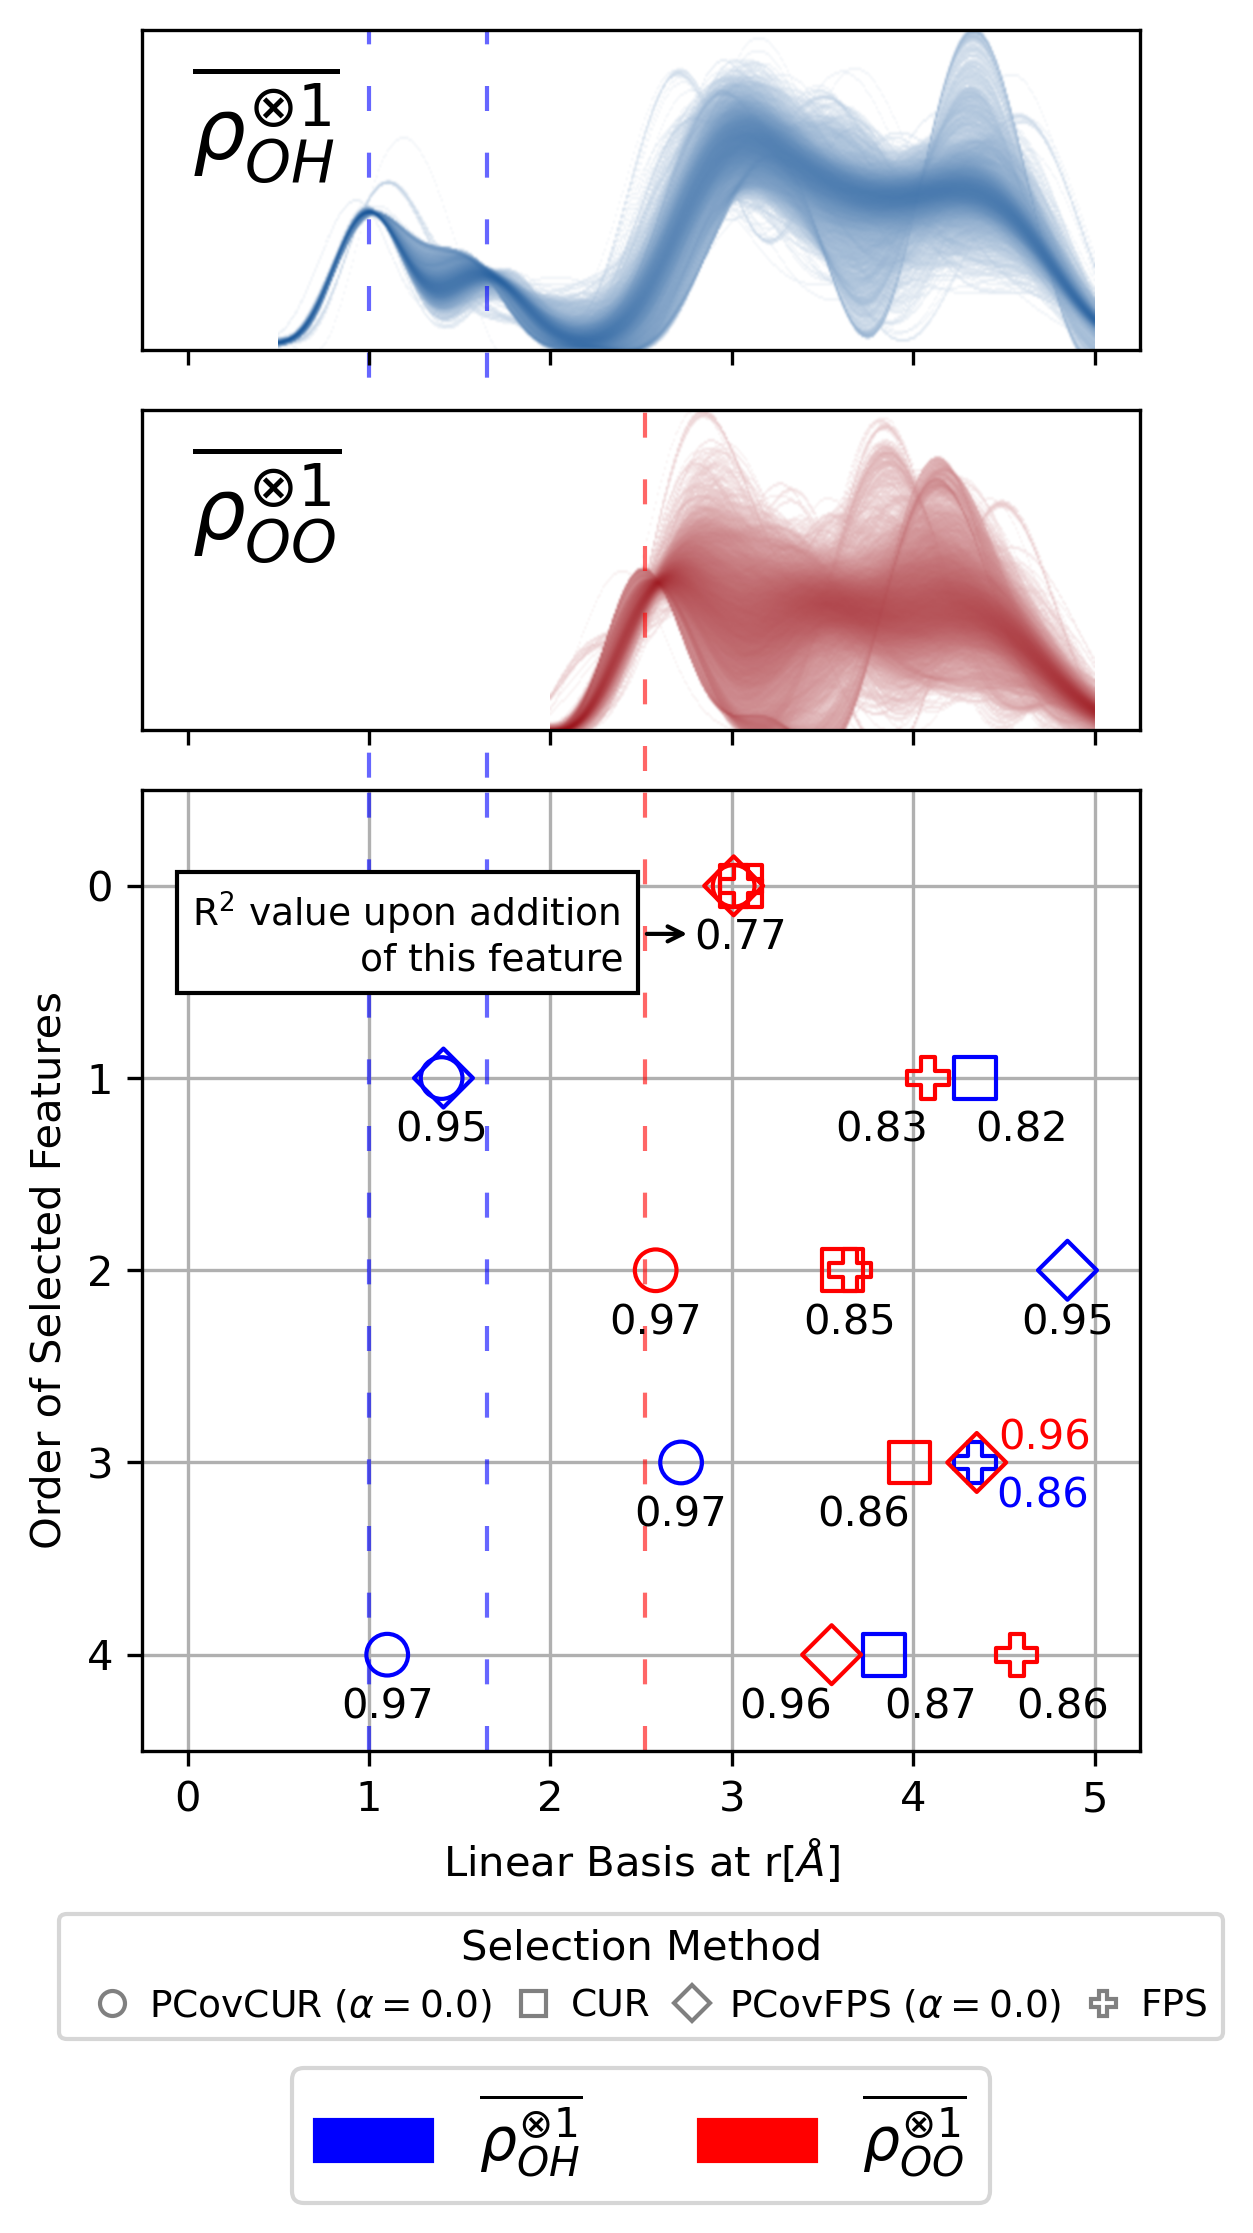

In [119]:
def fill_error(x, y, ax, cmap='Reds'):
    bins = np.linspace(0, y.max(), 150)
    global img_raw, img
    img_raw = np.flipud(np.array([np.histogram(yy, bins=bins)[0] for yy in y.T]).T)
    img = np.log(img_raw+1)
    ax.imshow(img, interpolation='bicubic',
              extent=[x.min(), x.max(),
                      bins.min(), bins.max()],
              aspect='auto',
              cmap=cmap)


fig = plt.figure(figsize=(4, 7.5), constrained_layout=True, dpi=300)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

#plot with g(r) on y axes
axes = fig.subplot_mosaic("""
A
B
C
""",
                          gridspec_kw=dict(height_ratios=(1, 1, 3)),
                          sharex=True)

ax_OH = axes["A"]
ax_OO = axes["B"]
ax_sel = axes["C"]

fill_error(o_rgrid, GR[:,len(h_rgrid):], ax_OO, custom_Red)
fill_error(h_rgrid, GR[:,:len(h_rgrid)], ax_OH, custom_Blue)
ax_OH.text(0.05,
           0.9,
           r'$\overline{\it{\rho^{\otimes 1}_{OH}}}$',
           fontsize=20,
           transform=ax_OH.transAxes,
           ha='left',
           va='top')
ax_OO.text(0.05,
           0.9,
           r'$\overline{\it{\rho^{\otimes 1}_{OO}}}$',
           fontsize=20,
           transform=ax_OO.transAxes,
           ha='left',
           va='top')
ax_OH.set_yticks([])
ax_OO.set_yticks([])

n = 5
ax_sel.set_axisbelow(True)
for i, m in enumerate(['blue', 'red']):
    for selector, marker in zip(
        [pcovcur2, cur2, pcovfps2, fps2],  #[m, "none", m, "none"],
        ["o", "s", "D", "P"]):
        w = np.where(selector.selected_idx_[:n] // len(h_rgrid) == i)[0]
        ax_sel.scatter(
            [[h_rgrid, o_rgrid][i][v % len(h_rgrid)] for v in selector.selected_idx_[w]],
            np.arange(n)[w],
            edgecolor=m,  # if mfc=='none' else 'k',
            marker=marker,
            facecolor='none',
            linewidth=1,
            s=100,
        )
        for ww in w:
            skip = [(0, 'o'), (0, 'D'), (0, 's'), (1, 'D'), (2, 's')]
            alignments = {(1, "P"): "right", (4, 'D'): 'right', (1, "s"): 'left',
                         (3, "s"): "right", (3, 'P'): 'left', (3, 'D'): 'left', 
                         (4, "s"): "left", (4, "P"): "left"}
            colors = {(3, "D"): "red", (3, 'P'): 'blue'}
            position_xalterations = {(3, "D"): 0.12, (3, 'P'): 0.12}
            position_yalterations = {(3, "D"): -0.4, (3, 'P'): -0.1}
            if (ww, marker) not in skip:
                v = selector.selected_idx_[ww]
                e = quick_test(selector.selected_idx_[:ww + 1])
                ax_sel.text(x=[h_rgrid, o_rgrid][i][v % len(h_rgrid)] 
                                + position_xalterations.get((ww, marker),0),
                            y=ww + 0.17 + position_yalterations.get((ww, marker),0),
                            s=r'{}'.format(round(e, 2)),
                            ha= alignments.get((ww, marker), 'center'),
                            va= 'top',
                            c=colors.get((ww,marker), 'black'))
            if (ww, marker) == (0, "P"):
                ax_sel.annotate(xy=([h_rgrid, o_rgrid][i][v % len(h_rgrid)]-0.25,ww + 0.25),
                                xytext = (2.4, ww+0.25),
                                text=r'R$^2$ value upon addition '+'\nof this feature',
                                arrowprops=dict(arrowstyle='->', lw=1, color='k'),
                                ha='right', va='center', fontsize=9,
                                bbox=dict(boxstyle="square,pad=0.4", fc='w', lw=1))
ax_sel.set_xlabel(r'Linear Basis at r[$\AA$]')
ax_sel.set_xlim((-0.25, 5.25))
ax_sel.set_ylim((-0.5, 4.5))
ax_sel.set_xticks(np.arange(0, 6, 1.0))
ax_sel.set_yticks(range(n))
ax_sel.set_ylabel('Order of Selected Features')
ax_sel.grid()
ax_sel.invert_yaxis()

legend1_elements = [
    Line2D([0], [0],
           marker='o',
           mfc='none',
           lw=0,
           mec='grey',
           label=r'PCovCUR ($\alpha='+str(pcovcur2.mixing)+'$)'),
    Line2D([0], [0], marker='s', mfc='none', lw=0, mec='grey',
           label='CUR'),
    Line2D([0], [0],
           marker='D',
           mfc='none',
           mec='grey',
           lw=0,
           label=r'PCovFPS ($\alpha='+str(pcovfps2.mixing)+'$)'),
    Line2D([0], [0], marker='P', mfc='none', lw=0, mec='grey', label='FPS')
]
legend2_elements = [
    Patch(facecolor='b', edgecolor='b', label=r'$\overline{\it{\rho^{\otimes 1}_{OH}}}$'),
    Patch(facecolor='r', edgecolor='r', label=r'$\overline{\it{\rho^{\otimes 1}_{OO}}}$')
]
leg1 = ax_sel.legend(handles=legend1_elements,
                     ncol=4,
                     handletextpad = 0.0,
                     columnspacing=0.1,
                     title='Selection Method',
                     bbox_to_anchor=(0.5, -0.15),
                     loc='upper center',
                    fontsize=9)
leg2 = ax_sel.legend(handles=legend2_elements,
                     ncol=4,
                     bbox_to_anchor=(0.5, -0.3),
                     loc='upper center',
                     fontsize=14)
ax_sel.add_artist(leg1)

for plot in ['ax_OH', 'ax_OO', 'ax_sel']:
    for line in [1.0, 1.65]:
        if plot == 'ax_OH':
            eval(plot).axvline(x=line,ymin=-3,ymax=1,c="blue",linewidth=1,zorder=0,
                               clip_on=False, linestyle=':', dashes=(6,10), alpha=0.6)
        elif plot == 'ax_sel':
            eval(plot).axvline(x=line,ymin=0,ymax=1,c="blue",linewidth=1,zorder=2,
                               clip_on=False, linestyle=':', dashes=(6,10), alpha=0.6)
    for line in [2.52]:
        if plot == 'ax_OO':
            eval(plot).axvline(x=line,ymin=-2,ymax=1,c="red",linewidth=1,zorder=0,
                               clip_on=False, linestyle='--', dashes=(6,10), alpha=0.6)
        elif plot == 'ax_sel':
            eval(plot).axvline(x=line,ymin=0,ymax=1,c="red",linewidth=1,zorder=2,
                               clip_on=False, linestyle=':', dashes=(6,10), alpha=0.6)

fig.tight_layout()

plt.savefig('vertical_stack.png', bbox_inches='tight')
plt.savefig('radial_spectrum-feature_selection.pdf', bbox_inches='tight')